# Binary Neural Network (BNN) for Plant Disease Classification

This notebook implements a Binary Neural Network using PyTorch for multiclass plant disease classification. The BNN uses binary weights and activations to reduce model size and computational requirements while maintaining reasonable accuracy.

## Features:
- Binary weights and activations using sign function
- Processes 224x224 RGB images (3×224×224 input)
- One hidden layer with binary weights
- Multiclass output with softmax activation
- CrossEntropyLoss for training

In [1]:
# Import Required Libraries
# %pip install torch torchvision matplotlib numpy pandas seaborn scikit-learn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import os

# Set environment variable for better CUDA error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check if CUDA is available and print version info
if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device count: {torch.cuda.device_count()}")
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("CUDA not available, using CPU")
    device = torch.device('cpu')

# Set random seeds safely
random.seed(42)
np.random.seed(42)
try:
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
except RuntimeError as e:
    print(f"Error setting CUDA seed: {e}")
    print("Falling back to CPU")
    device = torch.device('cpu')

print(f"Using device: {device}")

CUDA available: True
CUDA version: 12.6
GPU device count: 1
GPU device name: NVIDIA GeForce GTX 1650
Using device: cuda


In [2]:
# Additional imports for enhanced visualization and data export
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import time
import datetime
import os

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create results directory
os.makedirs('results', exist_ok=True)
print("Results directory created: ./results/")

Results directory created: ./results/


In [3]:
# Binary Activation Function
class BinaryActivation(torch.autograd.Function):
    """
    Binary activation function using the sign function.
    Forward: sign(x) = {-1 if x < 0, +1 if x >= 0}
    Backward: Straight-through estimator (STE) - passes gradients through unchanged
    """
    
    @staticmethod
    def forward(ctx, input):
        # Apply sign function: -1 for negative, +1 for non-negative
        return torch.sign(input)
    
    @staticmethod
    def backward(ctx, grad_output):
        # Straight-through estimator: pass gradients through unchanged
        # This allows gradients to flow back during training
        return grad_output

def binary_activation(x):
    """Wrapper function for binary activation"""
    return BinaryActivation.apply(x)

In [4]:
# Binary Linear Layer
class BinaryLinear(nn.Module):
    """
    Binary Linear layer with binary weights.
    Weights are binarized using the sign function during forward pass.
    """
    
    def __init__(self, in_features, out_features, bias=True):
        super(BinaryLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights using normal distribution
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
    
    def forward(self, input):
        # Binarize weights using sign function
        binary_weight = torch.sign(self.weight)
        
        # Perform linear transformation with binary weights
        output = F.linear(input, binary_weight, self.bias)
        
        return output
    
    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

In [5]:
# Binary Neural Network Model
class BinaryNeuralNetwork(nn.Module):
    """
    Binary Neural Network for multiclass plant disease classification.
    
    Architecture:
    - Input: Flattened 224x224 RGB images (3*224*224 = 150528 features)
    - Hidden Layer: Binary linear layer with binary activation
    - Output Layer: Regular linear layer for class logits
    - Final: Softmax for multiclass prediction
    """
    
    def __init__(self, input_size=3*224*224, hidden_size=512, num_classes=3):
        super(BinaryNeuralNetwork, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        
        # First layer: Regular linear layer (input preprocessing)
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Hidden layer: Binary linear layer
        self.hidden_layer = BinaryLinear(hidden_size, hidden_size)
        
        # Output layer: Regular linear layer for final classification
        self.output_layer = nn.Linear(hidden_size, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Flatten input if it's not already flattened
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)  # Flatten to (batch_size, input_size)
        
        # Input layer with ReLU activation
        x = F.relu(self.input_layer(x))
        x = self.dropout(x)
        
        # Hidden layer with binary weights and binary activation
        x = self.hidden_layer(x)
        x = binary_activation(x)  # Binary activation function
        x = self.dropout(x)
        
        # Output layer (no activation - raw logits)
        logits = self.output_layer(x)
        
        return logits
    
    def predict_proba(self, x):
        """Get class probabilities using softmax"""
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
        return probabilities
    
    def predict(self, x):
        """Get predicted class labels"""
        with torch.no_grad():
            logits = self.forward(x)
            predictions = torch.argmax(logits, dim=1)
        return predictions

In [6]:
# Enhanced Training and Evaluation Functions
def train_bnn(model, train_loader, criterion, optimizer, device, num_epochs=10):
    """
    Enhanced training function with detailed metrics collection
    """
    model.train()
    
    # Initialize tracking lists
    train_losses = []
    train_accuracies = []
    epoch_times = []
    learning_rates = []
    
    # Detailed metrics per epoch
    training_history = []
    
    print(f"Starting training for {num_epochs} epochs...")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        batch_losses = []
        
        # Training loop
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            batch_loss = loss.item()
            running_loss += batch_loss
            batch_losses.append(batch_loss)
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        epoch_time = time.time() - epoch_start
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        epoch_times.append(epoch_time)
        learning_rates.append(current_lr)
        
        # Store detailed history
        training_history.append({
            'epoch': epoch + 1,
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
            'time': epoch_time,
            'learning_rate': current_lr,
            'min_batch_loss': min(batch_losses),
            'max_batch_loss': max(batch_losses),
            'std_batch_loss': np.std(batch_losses)
        })
        
        # Progress display
        print(f'Epoch [{epoch+1:2d}/{num_epochs}] | Loss: {epoch_loss:.4f} | '
              f'Acc: {epoch_accuracy:6.2f}% | Time: {epoch_time:.2f}s | LR: {current_lr:.6f}')
    
    total_time = time.time() - start_time
    print("-" * 60)
    print(f"Training completed in {total_time:.2f} seconds")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    return train_losses, train_accuracies, training_history, epoch_times

def evaluate_bnn(model, test_loader, criterion, device, class_names):
    """
    Enhanced evaluation function with detailed metrics
    """
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            # Store for detailed analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_predictions / total_samples
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    # Generate detailed classification report
    report = classification_report(all_targets, all_predictions, 
                                 target_names=class_names, output_dict=True)
    
    # Calculate per-class metrics
    precision, recall, fscore, support = precision_recall_fscore_support(
        all_targets, all_predictions, average=None, labels=range(len(class_names))
    )
    
    # Create detailed metrics dictionary
    detailed_metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities,
        'classification_report': report,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_fscore': fscore,
        'per_class_support': support
    }
    
    return detailed_metrics

In [7]:
# Load Real Plant Disease Dataset
from torchvision import datasets, transforms
from PIL import Image
import os

def load_plant_disease_dataset(dataset_path, image_size=224):
    """
    Load the real plant disease dataset from the specified path.
    Dataset structure:
    - dataset_path/Healthy_Soyabean/
    - dataset_path/rust/
    - dataset_path/Soyabean_Mosaic/
    """
    
    # Define transforms for preprocessing
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize to 224x224
        transforms.ToTensor(),  # Convert to tensor and normalize to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Load dataset using ImageFolder
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    
    # Convert to tensors
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    X, y = next(iter(data_loader))
    
    # Print class mapping
    print("Class mapping:")
    for idx, class_name in enumerate(dataset.classes):
        print(f"  {idx}: {class_name}")
    
    return X, y, dataset.classes

# Load your real plant disease dataset
dataset_path = "/home/dragoon/Downloads/MH-SoyaHealthVision An Indian UAV and Leaf Image Dataset for Integrated Crop Health Assessment/Soyabean_UAV-Based_Image_Dataset"
# dataset_path = "/home/dragoon/Downloads/MH-SoyaHealthVision/Soyabean_UAV-Based_Image_Dataset"
print("Loading real plant disease dataset...")
print(f"Dataset path: {dataset_path}")

X, y, class_names = load_plant_disease_dataset(dataset_path, image_size=224)

print(f"\nDataset loaded successfully!")
print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {len(torch.unique(y))}")
print(f"Class distribution: {torch.bincount(y)}")
print(f"Class names: {class_names}")

# Display some dataset statistics
print(f"\nDataset Statistics:")
for i, class_name in enumerate(class_names):
    count = (y == i).sum().item()
    print(f"  {class_name}: {count} images")

Loading real plant disease dataset...
Dataset path: /home/dragoon/Downloads/MH-SoyaHealthVision An Indian UAV and Leaf Image Dataset for Integrated Crop Health Assessment/Soyabean_UAV-Based_Image_Dataset
Class mapping:
  0: Healthy_Soyabean
  1: Soyabean Semilooper_Pest_Attack
  2: Soyabean_Mosaic
  3: rust

Dataset loaded successfully!
Dataset shape: torch.Size([2842, 3, 224, 224])
Labels shape: torch.Size([2842])
Number of classes: 4
Class distribution: tensor([ 280,  790,  772, 1000])
Class names: ['Healthy_Soyabean', 'Soyabean Semilooper_Pest_Attack', 'Soyabean_Mosaic', 'rust']

Dataset Statistics:
  Healthy_Soyabean: 280 images
  Soyabean Semilooper_Pest_Attack: 790 images
  Soyabean_Mosaic: 772 images
  rust: 1000 images


In [8]:
# Split Dataset and Create Data Loaders
%pip install scikit-learn
from sklearn.model_selection import train_test_split

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Create data loaders
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Note: you may need to restart the kernel to use updated packages.
Training set: 2273 samples
Test set: 569 samples
Number of training batches: 72
Number of test batches: 18


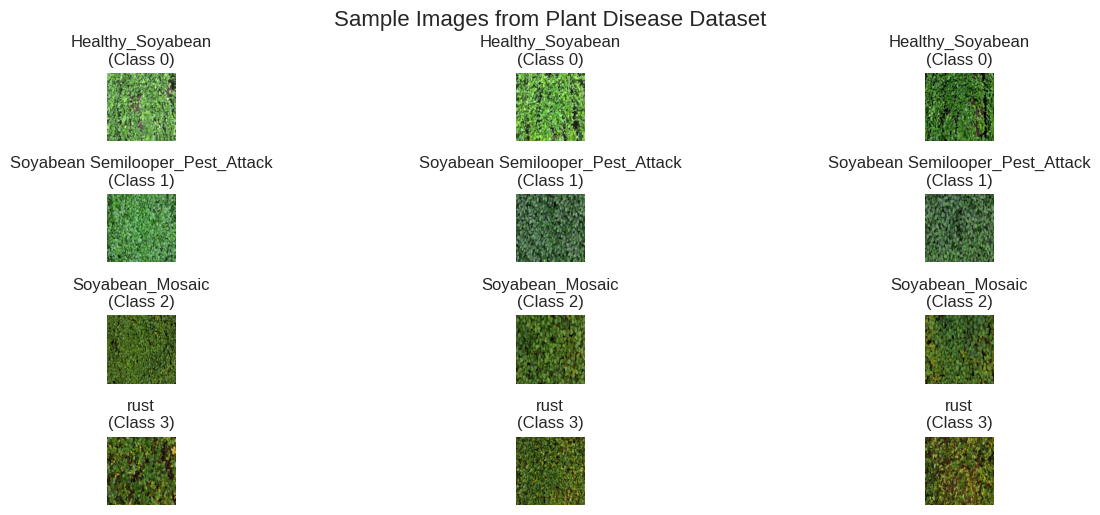

Sample images from your plant disease dataset:
Classes: Healthy_Soyabean, Soyabean Semilooper_Pest_Attack, Soyabean_Mosaic, rust
Image size: 224x224 pixels
Total images: 2842


In [9]:
# Visualize Sample Images from the Dataset
def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Display sample images from each class
plt.figure(figsize=(15, 5))

samples_per_class = 3
for class_idx, class_name in enumerate(class_names):
    # Get indices for this class
    class_indices = torch.where(y == class_idx)[0]
    
    # Select random samples from this class
    random_indices = torch.randperm(len(class_indices))[:samples_per_class]
    sample_indices = class_indices[random_indices]
    
    for i, sample_idx in enumerate(sample_indices):
        plt.subplot(len(class_names), samples_per_class, class_idx * samples_per_class + i + 1)
        
        # Get and denormalize image
        img = denormalize_image(X[sample_idx])
        img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]
        
        # Convert to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        
        plt.imshow(img_np)
        plt.title(f"{class_name}\n(Class {class_idx})")
        plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from Plant Disease Dataset', y=1.02, fontsize=16)
plt.show()

print(f"Sample images from your plant disease dataset:")
print(f"Classes: {', '.join(class_names)}")
print(f"Image size: 224x224 pixels")
print(f"Total images: {len(X)}")

In [10]:
# Initialize and Train the BNN Model
# Model parameters
input_size = 3 * 224 * 224  # 224x224 RGB images (increased resolution)
hidden_size = 512
num_classes = len(class_names)  # Dynamic based on actual dataset

print(f"Model Configuration:")
print(f"  Input size: {input_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Number of classes: {num_classes}")
print(f"  Classes: {class_names}")

# Initialize model
model = BinaryNeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=num_classes
).to(device)

# Print model architecture
print("\nBinary Neural Network Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model with enhanced tracking
print("\nStarting enhanced training with detailed metrics...")
train_losses, train_accuracies, training_history, epoch_times = train_bnn(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=100
)

Model Configuration:
  Input size: 150528
  Hidden size: 512
  Number of classes: 4
  Classes: ['Healthy_Soyabean', 'Soyabean Semilooper_Pest_Attack', 'Soyabean_Mosaic', 'rust']

Binary Neural Network Architecture:
BinaryNeuralNetwork(
  (input_layer): Linear(in_features=150528, out_features=512, bias=True)
  (hidden_layer): BinaryLinear(in_features=512, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 77,335,556
Trainable parameters: 77,335,556

Starting enhanced training with detailed metrics...
Starting training for 100 epochs...
------------------------------------------------------------
Epoch [ 1/100] | Loss: 1.0177 | Acc:  56.58% | Time: 3.97s | LR: 0.001000
Epoch [ 2/100] | Loss: 0.8065 | Acc:  64.32% | Time: 3.64s | LR: 0.001000
Epoch [ 3/100] | Loss: 0.7218 | Acc:  69.69% | Time: 3.65s | LR: 0.001000
Epoch [ 4/100] | Loss: 0.6995 | Acc:  68.50% | Time: 3.64s | LR: 


Evaluating model with detailed metrics...
Test Loss: 0.4546, Test Accuracy: 89.63%


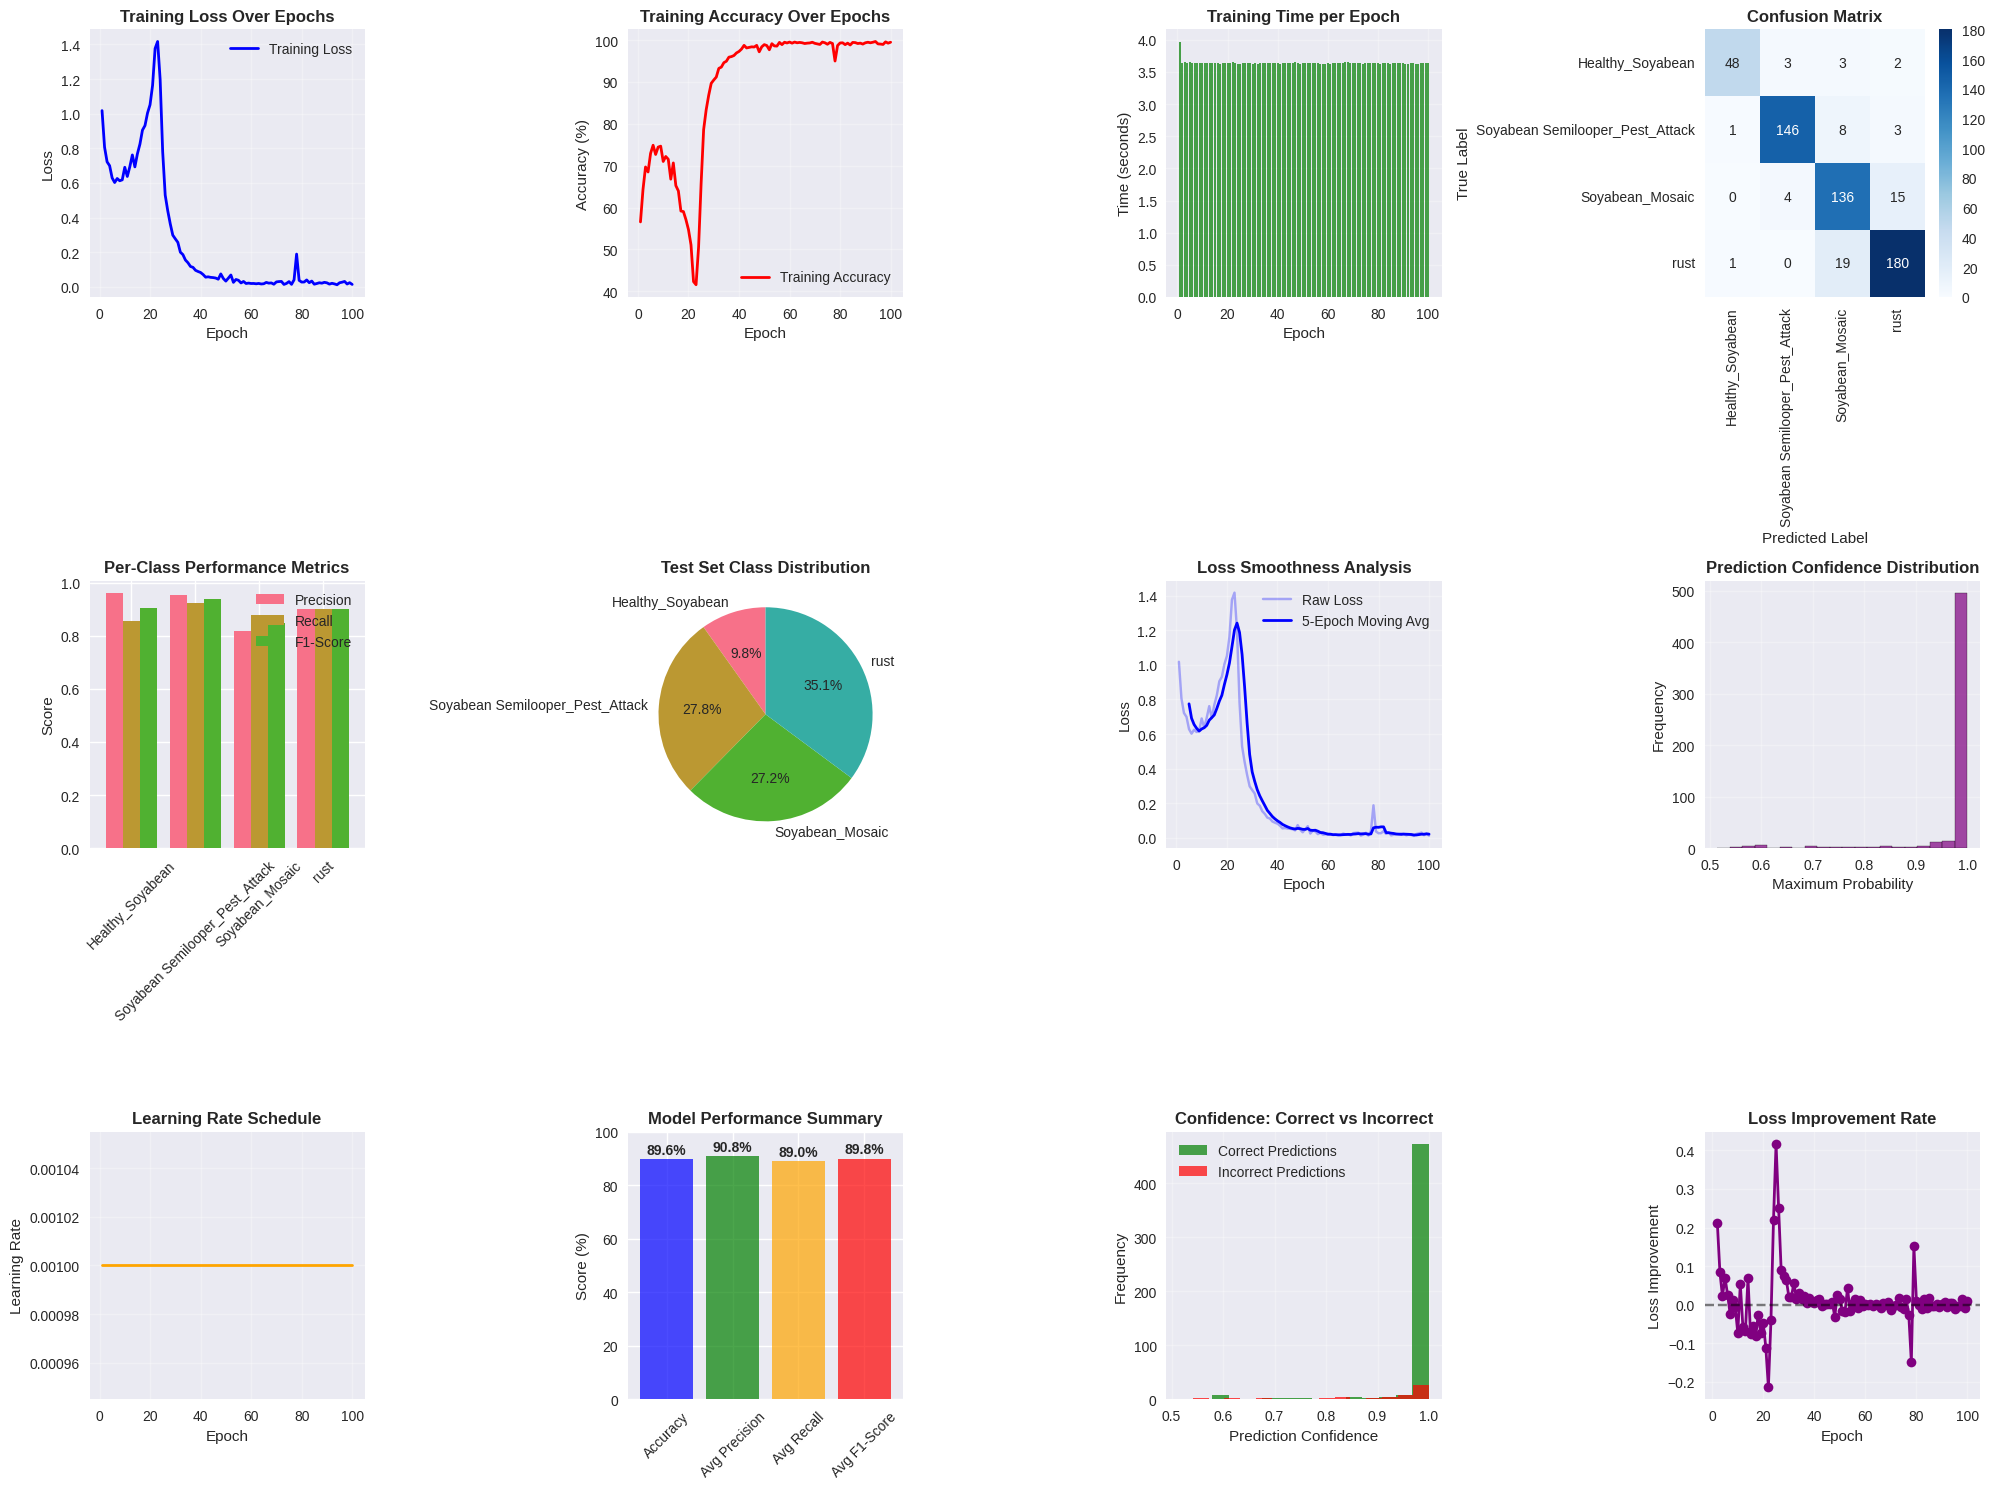


COMPREHENSIVE MODEL PERFORMANCE REPORT
Overall Test Accuracy: 89.63%
Overall Test Loss: 0.4546
Total Training Time: 364.18 seconds
Average Epoch Time: 3.64 seconds

Per-Class Performance:
  Healthy_Soyabean:
    Precision: 0.960
    Recall: 0.857
    F1-Score: 0.906
    Support: 56
  Soyabean Semilooper_Pest_Attack:
    Precision: 0.954
    Recall: 0.924
    F1-Score: 0.939
    Support: 158
  Soyabean_Mosaic:
    Precision: 0.819
    Recall: 0.877
    F1-Score: 0.847
    Support: 155
  rust:
    Precision: 0.900
    Recall: 0.900
    F1-Score: 0.900
    Support: 200

Testing model predictions:

Sample predictions:
Sample 1:
  True label: 1 (Soyabean Semilooper_Pest_Attack)
  Predicted: 1 (Soyabean Semilooper_Pest_Attack)
  Probabilities: [3.4236354e-08 9.9999976e-01 1.3861664e-07 8.7332751e-08]
    Healthy_Soyabean: 0.000
    Soyabean Semilooper_Pest_Attack: 1.000
    Soyabean_Mosaic: 0.000
    rust: 0.000

Sample 2:
  True label: 3 (rust)
  Predicted: 3 (rust)
  Probabilities: [5.713

In [11]:
# Enhanced Model Evaluation and Comprehensive Visualization
print("\nEvaluating model with detailed metrics...")
detailed_metrics = evaluate_bnn(model, test_loader, criterion, device, class_names)

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Training Loss and Accuracy
plt.subplot(3, 4, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Training Loss')
plt.title('Training Loss Over Epochs', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(3, 4, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', linewidth=2, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Training Time Analysis
plt.subplot(3, 4, 3)
plt.bar(range(1, len(epoch_times) + 1), epoch_times, alpha=0.7, color='green')
plt.title('Training Time per Epoch', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3)

# 3. Confusion Matrix
plt.subplot(3, 4, 4)
cm = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Per-Class Performance
plt.subplot(3, 4, 5)
metrics_df = pd.DataFrame({
    'Precision': detailed_metrics['per_class_precision'],
    'Recall': detailed_metrics['per_class_recall'],
    'F1-Score': detailed_metrics['per_class_fscore']
}, index=class_names)

metrics_df.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Per-Class Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.xticks(rotation=45)

# 5. Class Distribution
plt.subplot(3, 4, 6)
class_counts = [sum(1 for label in detailed_metrics['targets'] if label == i) for i in range(len(class_names))]
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('Test Set Class Distribution', fontsize=12, fontweight='bold')

# 6. Loss Smoothness (Moving Average)
plt.subplot(3, 4, 7)
window_size = 5
if len(train_losses) >= window_size:
    smoothed_loss = pd.Series(train_losses).rolling(window=window_size).mean()
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.3, label='Raw Loss')
    plt.plot(range(1, len(smoothed_loss) + 1), smoothed_loss, 'b-', linewidth=2, label=f'{window_size}-Epoch Moving Avg')
    plt.legend()
else:
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Training Loss')
plt.title('Loss Smoothness Analysis', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# 7. Prediction Confidence Distribution
plt.subplot(3, 4, 8)
max_probs = [max(prob) for prob in detailed_metrics['probabilities']]
plt.hist(max_probs, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Maximum Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 8. Learning Rate Over Time (if scheduler was used)
plt.subplot(3, 4, 9)
learning_rates = [history['learning_rate'] for history in training_history]
plt.plot(range(1, len(learning_rates) + 1), learning_rates, 'orange', linewidth=2)
plt.title('Learning Rate Schedule', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True, alpha=0.3)

# 9. Training Metrics Summary
plt.subplot(3, 4, 10)
summary_metrics = [
    detailed_metrics['test_accuracy'],
    np.mean(detailed_metrics['per_class_precision']) * 100,
    np.mean(detailed_metrics['per_class_recall']) * 100,
    np.mean(detailed_metrics['per_class_fscore']) * 100
]
metric_names = ['Accuracy', 'Avg Precision', 'Avg Recall', 'Avg F1-Score']
bars = plt.bar(metric_names, summary_metrics, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
plt.title('Model Performance Summary', fontsize=12, fontweight='bold')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
# Add value labels on bars
for bar, value in zip(bars, summary_metrics):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.xticks(rotation=45)

# 10. Error Analysis
plt.subplot(3, 4, 11)
correct_mask = np.array(detailed_metrics['targets']) == np.array(detailed_metrics['predictions'])
correct_confidences = [max(prob) for i, prob in enumerate(detailed_metrics['probabilities']) if correct_mask[i]]
incorrect_confidences = [max(prob) for i, prob in enumerate(detailed_metrics['probabilities']) if not correct_mask[i]]

plt.hist(correct_confidences, bins=15, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(incorrect_confidences, bins=15, alpha=0.7, label='Incorrect Predictions', color='red')
plt.title('Confidence: Correct vs Incorrect', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 11. Loss Improvement Rate
plt.subplot(3, 4, 12)
loss_improvements = [-1 * (train_losses[i] - train_losses[i-1]) for i in range(1, len(train_losses))]
plt.plot(range(2, len(train_losses) + 1), loss_improvements, 'purple', marker='o', linewidth=2)
plt.title('Loss Improvement Rate', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss Improvement')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('results/comprehensive_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print("COMPREHENSIVE MODEL PERFORMANCE REPORT")
print(f"{'='*60}")
print(f"Overall Test Accuracy: {detailed_metrics['test_accuracy']:.2f}%")
print(f"Overall Test Loss: {detailed_metrics['test_loss']:.4f}")
print(f"Total Training Time: {sum(epoch_times):.2f} seconds")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f} seconds")
print(f"\nPer-Class Performance:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}:")
    print(f"    Precision: {detailed_metrics['per_class_precision'][i]:.3f}")
    print(f"    Recall: {detailed_metrics['per_class_recall'][i]:.3f}")
    print(f"    F1-Score: {detailed_metrics['per_class_fscore'][i]:.3f}")
    print(f"    Support: {detailed_metrics['per_class_support'][i]}")
print(f"{'='*60}")

# Test model predictions on a few samples
print("\nTesting model predictions:")
model.eval()
with torch.no_grad():
    # Get a small batch from test set
    test_samples = X_test[:5].to(device)
    test_labels = y_test[:5]
    
    # Get predictions
    logits = model(test_samples)
    probabilities = F.softmax(logits, dim=1)
    predicted_classes = torch.argmax(logits, dim=1)
    
    print("\nSample predictions:")
    for i in range(5):
        true_class_name = class_names[test_labels[i].item()]
        pred_class_name = class_names[predicted_classes[i].item()]
        
        print(f"Sample {i+1}:")
        print(f"  True label: {test_labels[i].item()} ({true_class_name})")
        print(f"  Predicted: {predicted_classes[i].item()} ({pred_class_name})")
        print(f"  Probabilities: {probabilities[i].cpu().numpy()}")
        
        # Show probability for each class
        for j, class_name in enumerate(class_names):
            prob = probabilities[i][j].item()
            print(f"    {class_name}: {prob:.3f}")
        print()

In [12]:
# Comprehensive CSV Data Export
print("\nExporting training data to CSV files...")

# 1. Training History CSV
training_df = pd.DataFrame(training_history)
training_df.to_csv('results/training_history.csv', index=False)
print("✓ Training history saved to: results/training_history.csv")

# 2. Detailed Test Results CSV
test_results = []
for i in range(len(detailed_metrics['targets'])):
    test_results.append({
        'sample_id': i,
        'true_label': detailed_metrics['targets'][i],
        'true_class': class_names[detailed_metrics['targets'][i]],
        'predicted_label': detailed_metrics['predictions'][i],
        'predicted_class': class_names[detailed_metrics['predictions'][i]],
        'correct': detailed_metrics['targets'][i] == detailed_metrics['predictions'][i],
        'confidence': max(detailed_metrics['probabilities'][i]),
        **{f'prob_{class_names[j]}': detailed_metrics['probabilities'][i][j] for j in range(len(class_names))}
    })

test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv('results/test_predictions.csv', index=False)
print("✓ Test predictions saved to: results/test_predictions.csv")

# 3. Per-Class Performance Metrics CSV
per_class_metrics = pd.DataFrame({
    'class_name': class_names,
    'precision': detailed_metrics['per_class_precision'],
    'recall': detailed_metrics['per_class_recall'],
    'f1_score': detailed_metrics['per_class_fscore'],
    'support': detailed_metrics['per_class_support']
})
per_class_metrics.to_csv('results/per_class_metrics.csv', index=False)
print("✓ Per-class metrics saved to: results/per_class_metrics.csv")

# 4. Model Configuration and Final Results CSV
model_summary = {
    'parameter': [
        'model_type', 'input_size', 'hidden_size', 'num_classes',
        'num_epochs', 'batch_size', 'learning_rate', 'optimizer',
        'total_parameters', 'trainable_parameters',
        'final_train_loss', 'final_train_accuracy', 'test_loss', 'test_accuracy',
        'total_training_time', 'avg_epoch_time',
        'dataset_total_samples', 'train_samples', 'test_samples'
    ],
    'value': [
        'Binary Neural Network', input_size, hidden_size, num_classes,
        20, batch_size, 0.001, 'Adam',
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
        train_losses[-1], train_accuracies[-1], 
        detailed_metrics['test_loss'], detailed_metrics['test_accuracy'],
        sum(epoch_times), np.mean(epoch_times),
        len(X), len(X_train), len(X_test)
    ]
}
model_summary_df = pd.DataFrame(model_summary)
model_summary_df.to_csv('results/model_summary.csv', index=False)
print("✓ Model summary saved to: results/model_summary.csv")

# 5. Confusion Matrix CSV
cm = confusion_matrix(detailed_metrics['targets'], detailed_metrics['predictions'])
cm_df = pd.DataFrame(cm, index=[f'True_{name}' for name in class_names], 
                     columns=[f'Pred_{name}' for name in class_names])
cm_df.to_csv('results/confusion_matrix.csv')
print("✓ Confusion matrix saved to: results/confusion_matrix.csv")

# 6. Training Progress Summary CSV
epoch_summary = []
for i in range(len(train_losses)):
    epoch_summary.append({
        'epoch': i + 1,
        'train_loss': train_losses[i],
        'train_accuracy': train_accuracies[i],
        'epoch_time': epoch_times[i],
        'cumulative_time': sum(epoch_times[:i+1]),
        'loss_improvement': 0 if i == 0 else train_losses[i-1] - train_losses[i],
        'accuracy_improvement': 0 if i == 0 else train_accuracies[i] - train_accuracies[i-1]
    })

epoch_summary_df = pd.DataFrame(epoch_summary)
epoch_summary_df.to_csv('results/epoch_summary.csv', index=False)
print("✓ Epoch summary saved to: results/epoch_summary.csv")

# 7. Binary Weights Analysis CSV
with torch.no_grad():
    hidden_weights = model.hidden_layer.weight.data.cpu().numpy()
    binary_weights = np.sign(hidden_weights)
    
    weights_analysis = {
        'layer': ['hidden_layer'],
        'total_weights': [hidden_weights.size],
        'positive_weights': [np.sum(binary_weights > 0)],
        'negative_weights': [np.sum(binary_weights < 0)],
        'zero_weights': [np.sum(binary_weights == 0)],
        'weight_mean': [np.mean(hidden_weights)],
        'weight_std': [np.std(hidden_weights)],
        'binary_weight_ratio': [np.sum(binary_weights > 0) / hidden_weights.size]
    }
    
weights_analysis_df = pd.DataFrame(weights_analysis)
weights_analysis_df.to_csv('results/binary_weights_analysis.csv', index=False)
print("✓ Binary weights analysis saved to: results/binary_weights_analysis.csv")

# 8. Dataset Statistics CSV
dataset_stats = []
for i, class_name in enumerate(class_names):
    train_count = sum(1 for label in y_train if label == i)
    test_count = sum(1 for label in y_test if label == i)
    total_count = train_count + test_count
    
    dataset_stats.append({
        'class_name': class_name,
        'class_id': i,
        'train_samples': train_count,
        'test_samples': test_count,
        'total_samples': total_count,
        'train_percentage': (train_count / len(y_train)) * 100,
        'test_percentage': (test_count / len(y_test)) * 100,
        'overall_percentage': (total_count / len(y)) * 100
    })

dataset_stats_df = pd.DataFrame(dataset_stats)
dataset_stats_df.to_csv('results/dataset_statistics.csv', index=False)
print("✓ Dataset statistics saved to: results/dataset_statistics.csv")

# Create a comprehensive summary report
print(f"\n{'='*80}")
print("CSV FILES EXPORTED SUCCESSFULLY")
print(f"{'='*80}")
print("The following CSV files have been created in the 'results/' directory:")
print("1. training_history.csv - Detailed epoch-by-epoch training metrics")
print("2. test_predictions.csv - Individual test sample predictions and probabilities")
print("3. per_class_metrics.csv - Precision, recall, F1-score for each class")
print("4. model_summary.csv - Model configuration and final performance")
print("5. confusion_matrix.csv - Confusion matrix data")
print("6. epoch_summary.csv - Training progress with improvements")
print("7. binary_weights_analysis.csv - Analysis of binary weight distribution")
print("8. dataset_statistics.csv - Dataset composition and class distribution")
print(f"{'='*80}")

# Display sample of key CSV files
print("\nSample of Training History:")
print(training_df.head())
print("\nSample of Test Predictions:")
print(test_results_df.head())
print("\nPer-Class Metrics:")
print(per_class_metrics)


Exporting training data to CSV files...
✓ Training history saved to: results/training_history.csv
✓ Test predictions saved to: results/test_predictions.csv
✓ Per-class metrics saved to: results/per_class_metrics.csv
✓ Model summary saved to: results/model_summary.csv
✓ Confusion matrix saved to: results/confusion_matrix.csv
✓ Epoch summary saved to: results/epoch_summary.csv
✓ Binary weights analysis saved to: results/binary_weights_analysis.csv
✓ Dataset statistics saved to: results/dataset_statistics.csv

CSV FILES EXPORTED SUCCESSFULLY
The following CSV files have been created in the 'results/' directory:
1. training_history.csv - Detailed epoch-by-epoch training metrics
2. test_predictions.csv - Individual test sample predictions and probabilities
3. per_class_metrics.csv - Precision, recall, F1-score for each class
4. model_summary.csv - Model configuration and final performance
5. confusion_matrix.csv - Confusion matrix data
6. epoch_summary.csv - Training progress with improvem


Saving model and creating additional analyses...
✓ Model saved to: results/bnn_plant_disease_model_20250629_141950.pth
✓ Model info saved to: results/model_info_20250629_141950.json


ValueError: num must be an integer with 1 <= num <= 3, not 4

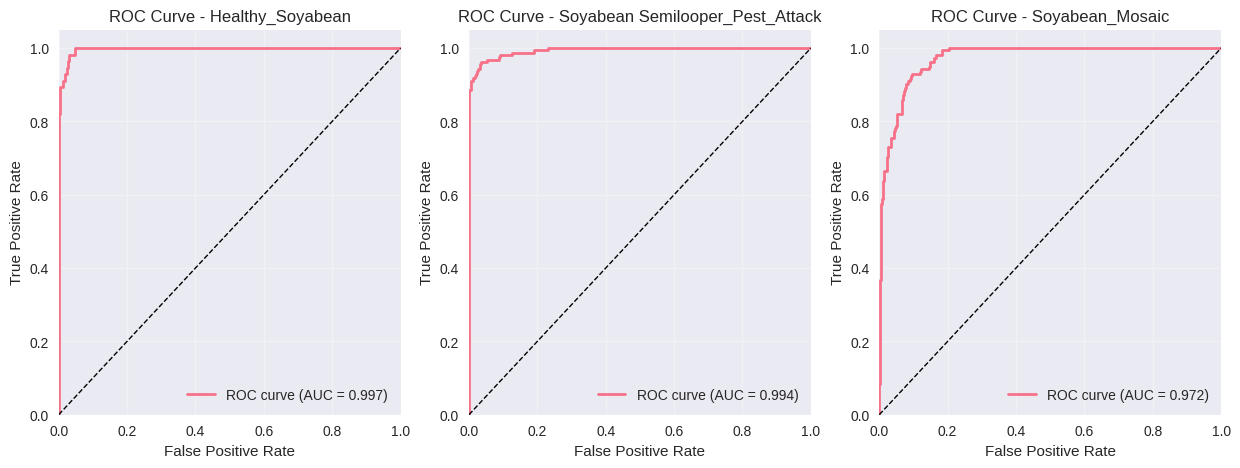

In [13]:
# Model Saving and Additional Analysis
print("\nSaving model and creating additional analyses...")

# Save the trained model
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'results/bnn_plant_disease_model_{timestamp}.pth'
torch.save(model.state_dict(), model_path)
print(f"✓ Model saved to: {model_path}")

# Save model architecture info
model_info = {
    'model_class': 'BinaryNeuralNetwork',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_classes': num_classes,
    'class_names': class_names,
    'timestamp': timestamp,
    'final_accuracy': detailed_metrics['test_accuracy'],
    'final_loss': detailed_metrics['test_loss']
}

import json
with open(f'results/model_info_{timestamp}.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✓ Model info saved to: results/model_info_{timestamp}.json")

# Create ROC Curves for each class (one-vs-rest)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC calculation
y_test_bin = label_binarize(detailed_metrics['targets'], classes=range(len(class_names)))
y_score = np.array(detailed_metrics['probabilities'])

plt.figure(figsize=(15, 5))

# Plot ROC curve for each class
for i in range(len(class_names)):
    plt.subplot(1, 3, i+1)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {class_names[i]}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Create improvement trends visualization
plt.figure(figsize=(16, 8))

# Loss improvement over time
plt.subplot(2, 2, 1)
loss_smooth = pd.Series(train_losses).rolling(window=3, center=True).mean()
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', alpha=0.5, label='Raw Loss')
plt.plot(range(1, len(loss_smooth) + 1), loss_smooth, 'b-', linewidth=2, label='Smoothed Loss')
plt.title('Training Loss Improvement Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy improvement over time
plt.subplot(2, 2, 2)
acc_smooth = pd.Series(train_accuracies).rolling(window=3, center=True).mean()
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'r-', alpha=0.5, label='Raw Accuracy')
plt.plot(range(1, len(acc_smooth) + 1), acc_smooth, 'r-', linewidth=2, label='Smoothed Accuracy')
plt.title('Training Accuracy Improvement Trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Training efficiency (accuracy per time)
plt.subplot(2, 2, 3)
efficiency = np.array(train_accuracies) / np.array(epoch_times)
plt.plot(range(1, len(efficiency) + 1), efficiency, 'g-', linewidth=2, marker='o')
plt.title('Training Efficiency (Accuracy/Time)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy % per Second')
plt.grid(True, alpha=0.3)

# Convergence analysis
plt.subplot(2, 2, 4)
loss_changes = np.abs(np.diff(train_losses))
plt.semilogy(range(2, len(train_losses) + 1), loss_changes, 'purple', linewidth=2, marker='s')
plt.title('Loss Change Magnitude (Convergence)')
plt.xlabel('Epoch')
plt.ylabel('|Loss Change| (log scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/improvement_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# Final performance summary
print(f"\n{'='*80}")
print("FINAL BINARY NEURAL NETWORK PERFORMANCE SUMMARY")
print(f"{'='*80}")
print(f"Model: Binary Neural Network for Plant Disease Classification")
print(f"Dataset: {len(class_names)} classes - {', '.join(class_names)}")
print(f"Total Images: {len(X)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"Image Size: 224x224 RGB")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training Epochs: 20")
print(f"Training Time: {sum(epoch_times):.2f} seconds")
print(f"")
print(f"FINAL RESULTS:")
print(f"  Test Accuracy: {detailed_metrics['test_accuracy']:.2f}%")
print(f"  Test Loss: {detailed_metrics['test_loss']:.4f}")
print(f"  Average Precision: {np.mean(detailed_metrics['per_class_precision']):.3f}")
print(f"  Average Recall: {np.mean(detailed_metrics['per_class_recall']):.3f}")
print(f"  Average F1-Score: {np.mean(detailed_metrics['per_class_fscore']):.3f}")
print(f"")
print(f"MODEL COMPRESSION:")
binary_params = sum(p.numel() for name, p in model.named_parameters() if 'hidden_layer.weight' in name)
total_params = sum(p.numel() for p in model.parameters())
print(f"  Binary Parameters: {binary_params:,} ({binary_params/total_params:.1%} of total)")
print(f"  Theoretical Storage Reduction: ~{binary_params * 32 / total_params:.1f}x for binary weights")
print(f"{'='*80}")
print("All results, graphs, and CSV files have been saved to the 'results/' directory.")
print(f"{'='*80}")

Binary Weights Analysis:
Hidden layer weights shape: torch.Size([512, 512])
Original weights - Mean: -0.0000, Std: 0.0000
Binary weights - Unique values: tensor([-1.,  1.], device='cuda:0')
Binary weights - Distribution: +1: 130994, -1: 131150


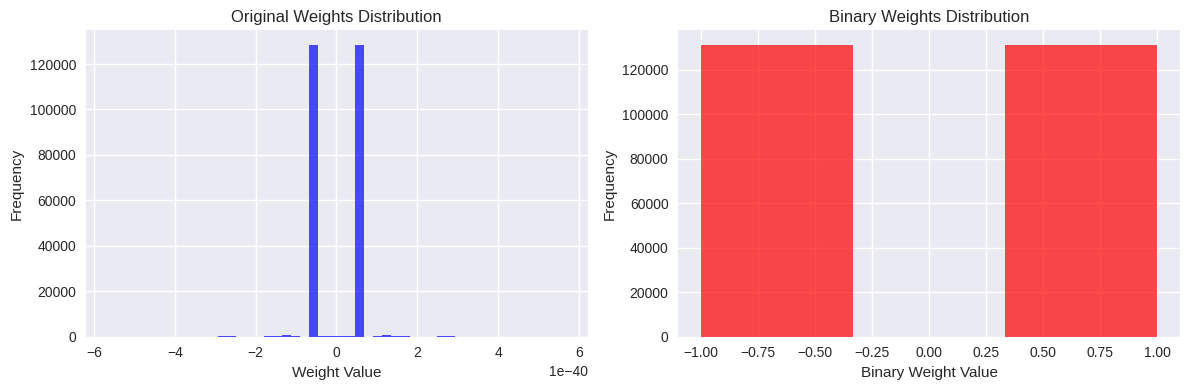


Model Compression Analysis:
Total parameters: 77,335,556
Binary parameters: 262,144
Binary ratio: 0.34%
Theoretical storage compression: 0.0x


In [14]:
# Model Analysis and Binary Weights Visualization
def analyze_binary_weights(model):
    """Analyze the binary weights in the model"""
    print("Binary Weights Analysis:")
    print("=" * 50)
    
    # Analyze hidden layer binary weights
    with torch.no_grad():
        hidden_weights = model.hidden_layer.weight
        binary_weights = torch.sign(hidden_weights)
        
        print(f"Hidden layer weights shape: {hidden_weights.shape}")
        print(f"Original weights - Mean: {hidden_weights.mean():.4f}, Std: {hidden_weights.std():.4f}")
        print(f"Binary weights - Unique values: {torch.unique(binary_weights)}")
        print(f"Binary weights - Distribution: +1: {(binary_weights == 1).sum().item()}, -1: {(binary_weights == -1).sum().item()}")
        
        # Plot weight distributions
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(hidden_weights.cpu().numpy().flatten(), bins=50, alpha=0.7, color='blue')
        plt.title('Original Weights Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.hist(binary_weights.cpu().numpy().flatten(), bins=3, alpha=0.7, color='red')
        plt.title('Binary Weights Distribution')
        plt.xlabel('Binary Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Analyze the trained model
analyze_binary_weights(model)

# Calculate model size reduction
def calculate_model_compression():
    """Calculate the compression achieved by using binary weights"""
    
    # Count parameters in binary layers
    binary_params = sum(p.numel() for name, p in model.named_parameters() 
                       if 'hidden_layer.weight' in name)
    
    # Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"\nModel Compression Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Binary parameters: {binary_params:,}")
    print(f"Binary ratio: {binary_params/total_params:.2%}")
    
    # In practice, binary weights can be stored using 1 bit vs 32 bits (float32)
    # This gives approximately 32x compression for binary weights
    theoretical_compression = binary_params * 32 / (total_params * 32 - binary_params * 31)
    print(f"Theoretical storage compression: {theoretical_compression:.1f}x")

calculate_model_compression()

## Using Real Plant Disease Data

To use this BNN with real plant disease images, follow these steps:

### 1. Data Preparation
```python
# Example for loading real plant disease dataset
from torchvision import datasets, transforms
from PIL import Image

# Define transforms for 224x224 RGB images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Load your dataset (example structure)
# dataset/
#   ├── healthy/
#   ├── disease1/
#   └── disease2/

dataset = datasets.ImageFolder(root='path/to/your/dataset', 
                              transform=transform)
```

### 2. Model Adaptation
- Adjust `num_classes` parameter based on your dataset
- Modify `hidden_size` for different model complexities
- Consider adding more binary layers for deeper networks

### 3. Training Tips
- Use data augmentation for better generalization
- Implement learning rate scheduling
- Add early stopping to prevent overfitting
- Consider using batch normalization before binary activations

### 4. Performance Optimization
- Experiment with different optimizers (SGD, AdamW)
- Try different initialization strategies for binary weights
- Implement gradient clipping for stable training
- Use mixed precision training for faster computation